<a href="https://colab.research.google.com/github/Renzo0o0/black-scholes-implied-volatility/blob/main/Black%E2%80%93Scholes_Pricing_Engine_Greeks_%26_Implied_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Strike | MarketPrice | ImpliedVol
    60 |    40.3062 | 0.25000000012743145
    65 |    35.3558 | 0.250000003579885
    70 |    30.4594 | 0.2500000008725194
    75 |    25.6841 | 0.25000000000000017
    80 |    21.1296 | 0.2500000000075054
    85 |    16.9154 | 0.24999999999999997
    90 |    13.1550 | 0.25000000004046735
    95 |     9.9308 | 0.25000000000000216
   100 |     7.2778 | 0.24999999998932262
   105 |     5.1819 | 0.24999999999999992
   110 |     3.5892 | 0.25000000000224293
   115 |     2.4224 | 0.24999999999999978
   120 |     1.5960 | 0.25000000000000266
   125 |     1.0284 | 0.25000000000184985
   130 |     0.6493 | 0.25000000032498115
   135 |     0.4024 | 0.25000000000000366
   140 |     0.2453 | 0.2500000000044211


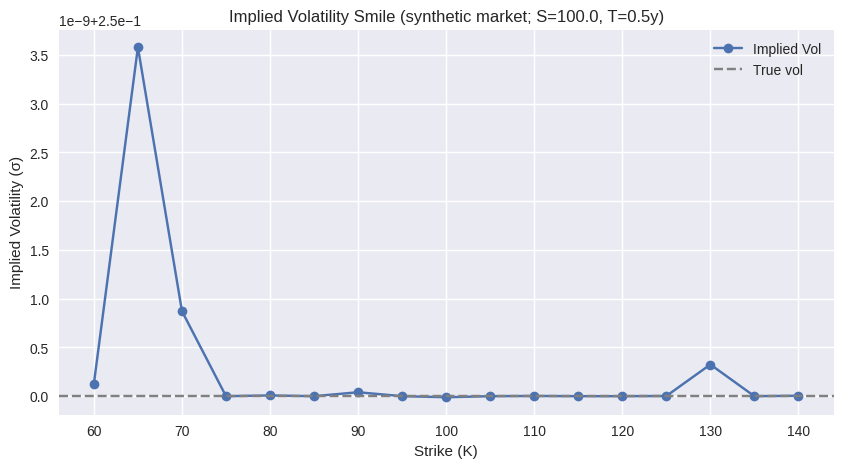


Single-contract example (K=100):
Market price (synthetic): 7.277813
Implied vol (K=100): 0.250000
BS price (using implied vol): 7.277813
Greeks at implied vol:
  Delta_call: 0.546440
  Delta_put: -0.453560
  Gamma: 0.022415
  Vega: 28.018130
  Theta_call: -7.478195
  Theta_put: -6.483182
  Rho_call: 23.683107
  Rho_put: -26.067517


In [2]:
# Black–Scholes pricing + Greeks + Implied Volatility + Smile
# Repo: black-scholes-implied-volatility
# Author: Andrés R.
# References: Hull, Wilmott, Hilpisch
# Single-cell implementation, ready for Google Colab

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10,6)

# -------------------------
# 1) Black–Scholes FUNCTIONS
# -------------------------
# Closed-form formulas for European call and put (no dividends).
# Uses continuously compounded rates.

def bs_price(call_put_flag, S, K, T, r, sigma):
    """
    Black–Scholes price for European option.
    call_put_flag: 'call' or 'put'
    S: spot
    K: strike
    T: time to maturity (years)
    r: continuously compounded risk-free rate
    sigma: volatility (annual)
    """
    if T <= 0 or sigma <= 0:
        # Immediate payoff (degenerate case)
        if call_put_flag.lower().startswith('c'):
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if call_put_flag.lower().startswith('c'):
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

def bs_greeks(S, K, T, r, sigma):
    """
    Analytical Greeks for European option (Black–Scholes).
    Returns a dict: Delta_call, Delta_put, Gamma, Vega, Theta_call, Theta_put, Rho_call, Rho_put
    """
    if T <= 0 or sigma <= 0:
        # Degenerate case: Greeks are not defined in continuous fashion
        return {
            'Delta_call': 1.0 if S > K else 0.0,
            'Delta_put': -1.0 if S < K else 0.0,
            'Gamma': 0.0,
            'Vega': 0.0,
            'Theta_call': 0.0,
            'Theta_put': 0.0,
            'Rho_call': 0.0,
            'Rho_put': 0.0
        }

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)
    cdf_minus_d1 = norm.cdf(-d1)
    cdf_minus_d2 = norm.cdf(-d2)

    delta_call = cdf_d1
    delta_put  = cdf_d1 - 1.0
    gamma = pdf_d1 / (S * sigma * math.sqrt(T))
    vega = S * pdf_d1 * math.sqrt(T)  # per 1 vol point (not percent)
    theta_call = - (S * pdf_d1 * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * cdf_d2
    theta_put  = - (S * pdf_d1 * sigma) / (2 * math.sqrt(T)) + r * K * math.exp(-r * T) * cdf_minus_d2
    rho_call = K * T * math.exp(-r * T) * cdf_d2
    rho_put  = -K * T * math.exp(-r * T) * cdf_minus_d2

    return {
        'Delta_call': delta_call,
        'Delta_put': delta_put,
        'Gamma': gamma,
        'Vega': vega,
        'Theta_call': theta_call,
        'Theta_put': theta_put,
        'Rho_call': rho_call,
        'Rho_put': rho_put
    }

# ---------------------------------------
# 2) IMPLIED VOLATILITY (Newton + Bisection)
# ---------------------------------------
def implied_vol(option_price, call_put_flag, S, K, T, r, sigma0=0.2, tol=1e-8, maxiter=100):
    """
    Implied volatility solver.
    Tries Newton–Raphson first, falls back to bisection if NR fails.
    option_price: observed market price
    sigma0: initial guess
    """
    # Edge cases
    if option_price <= 0:
        return 0.0

    # Newton–Raphson
    sigma = sigma0
    for i in range(maxiter):
        price = bs_price(call_put_flag, S, K, T, r, sigma)
        greeks = bs_greeks(S, K, T, r, sigma)
        vega = greeks['Vega']
        price_diff = price - option_price
        if abs(price_diff) < tol:
            return max(sigma, 0.0)
        # If vega is extremely small, avoid division by small number
        if vega < 1e-8:
            break
        sigma = sigma - price_diff / vega
        # keep sigma in reasonable bounds
        if sigma <= 0 or sigma > 5:
            break

    # Bisection fallback on [a,b]
    a = 1e-9
    b = 5.0
    fa = bs_price(call_put_flag, S, K, T, r, a) - option_price
    fb = bs_price(call_put_flag, S, K, T, r, b) - option_price
    if fa * fb > 0:
        # No sign change — implied vol may not exist in range; return NaN
        return np.nan

    for i in range(100):
        mid = 0.5 * (a + b)
        fmid = bs_price(call_put_flag, S, K, T, r, mid) - option_price
        if abs(fmid) < tol:
            return mid
        if fa * fmid < 0:
            b = mid
            fb = fmid
        else:
            a = mid
            fa = fmid
    return 0.5 * (a + b)

# ---------------------------------------
# 3) VOLATILITY SMILE (compute implied vols across strikes)
# ---------------------------------------
def compute_smile(market_prices, S, T, r, call_put_flag='call', sigma_guess=0.2):
    """
    market_prices: dict or list of (K -> market_price)
    Returns DataFrame with columns: K, market_price, implied_vol, model_price
    """
    rows = []
    for K, mprice in market_prices.items():
        iv = implied_vol(mprice, call_put_flag, S, K, T, r, sigma0=sigma_guess)
        model_p = bs_price(call_put_flag, S, K, T, r, iv if not np.isnan(iv) else sigma_guess)
        rows.append((K, mprice, iv, model_p))
    df = pd.DataFrame(rows, columns=['K','market_price','implied_vol','model_price'])
    df = df.sort_values('K').reset_index(drop=True)
    return df

# ---------------------------------------
# 4) EXAMPLE & VISUALS (run as-is)
# ---------------------------------------

# Example parameters
S = 100.0
r = 0.01
T = 0.5         # 6 months
sigma_true = 0.25

# Create synthetic "market" option prices using a true sigma (to demonstrate implied vol)
strikes = np.arange(60, 141, 5)  # 60 to 140 by 5
market_prices = {}
for K in strikes:
    # Use Black-Scholes with sigma_true to create a synthetic market price
    market_prices[K] = bs_price('call', S, K, T, r, sigma_true)

# Compute implied vol smile from synthetic market prices
smile_df = compute_smile(market_prices, S, T, r, call_put_flag='call', sigma_guess=0.2)

# Print results
print("Strike | MarketPrice | ImpliedVol")
for i, row in smile_df.iterrows():
    print(f"{int(row['K']):>6} | {row['market_price']:10.4f} | {row['implied_vol'] if not np.isnan(row['implied_vol']) else 'NaN':>8}")

# Plot smile
plt.figure(figsize=(10,5))
plt.plot(smile_df['K'], smile_df['implied_vol'], marker='o', label='Implied Vol')
plt.axhline(sigma_true, color='grey', linestyle='--', label='True vol')
plt.title(f'Implied Volatility Smile (synthetic market; S={S}, T={T}y)')
plt.xlabel('Strike (K)')
plt.ylabel('Implied Volatility (σ)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------
# 5) QUICK REPORT (single-line summary)
# ---------------------------------------
# Example: compute a single price + Greeks for a given strike
K0 = 100
market_price_K0 = market_prices[K0]
iv_K0 = implied_vol(market_price_K0, 'call', S, K0, T, r)
price_bs = bs_price('call', S, K0, T, r, iv_K0)
greeks = bs_greeks(S, K0, T, r, iv_K0)

print("\nSingle-contract example (K=100):")
print(f"Market price (synthetic): {market_price_K0:.6f}")
print(f"Implied vol (K=100): {iv_K0:.6f}")
print(f"BS price (using implied vol): {price_bs:.6f}")
print("Greeks at implied vol:")
for k,v in greeks.items():
    print(f"  {k}: {v:.6f}")

# End of single-cell script
